<a href="https://colab.research.google.com/github/aswinaus/graphrag/blob/main/Advanced_llms_knowledge_graph_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this comprehensive notebook, we'll build a knowledge graph-enhanced Retrieval-Augmented Generation (RAG) system using hotel reviews data. This represents a significant advancement over traditional RAG approaches that treat documents as isolated pieces of information.

Let's start by understanding the difference between traditional RAG and graph RAG:

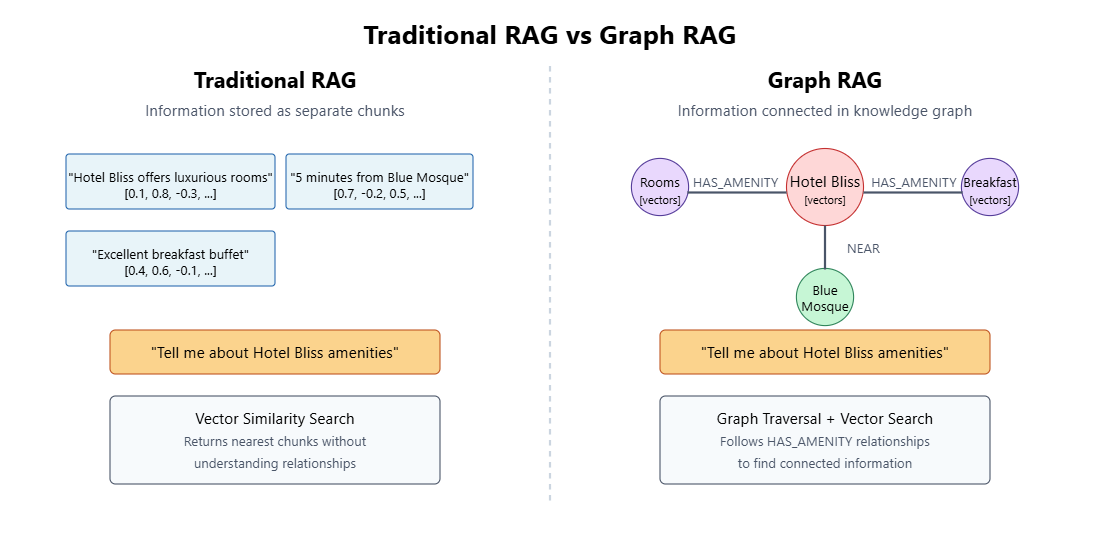

As we can see in the diagram above, traditional RAG treats each document as an isolated unit, while graph RAG captures the relationships between entities mentioned in the documents. This structural understanding enables more sophisticated querying and better answers.

## Architecture Overview
Our graph RAG system will have several key components:

architecture (1).svg

## Learning Outcomes
After completing this notebook, you will be able to:

1. **Build Knowledge Graphs**
   - Construct graph representations from structured and unstructured data
   - Use NetworkX for graph manipulation and visualization
   - Migrate graphs to Neo4j for persistence and querying
   - Extract entities and relationships from text using LLMs
   
   Key skills: Graph modeling, entity extraction, relationship mapping

2. **Implement Graph RAG**
   - Create hybrid search combining vector and graph capabilities
   - Write graph queries using the Cypher query language
   - Build vector indices over graph nodes
   - Combine semantic search with graph traversal
   
   Key skills: Neo4j, Cypher, vector indexing, hybrid search strategies

3. **Evaluate RAG Approaches**
   - Compare traditional RAG vs graph RAG performance
   - Identify use cases where graph structure improves results
   - Measure and analyze query response quality
   - Debug and optimize graph RAG systems
   
   Key skills: RAG evaluation, performance analysis, system optimization

## Why Graph RAG Matters

Traditional RAG has several key limitations:
- Treats documents as independent chunks without understanding connections
- Cannot easily aggregate information across related items
- Limited ability to follow chains of reasoning
- Misses contextual relationships between entities

Graph RAG addresses these limitations by:
- Capturing explicit relationships between entities in a knowledge graph
- Enabling multi-hop reasoning by traversing relationships
- Combining semantic search with structural graph queries
- Supporting relationship-aware aggregation and pattern matching

For our hotel reviews example, this means we can:
- Connect hotels to their locations, amenities, and reviews
- Find patterns like "highly-rated hotels near specific landmarks"
- Aggregate sentiment across related entities
- Answer complex queries requiring multiple relationship hops
- Combine factual data with review sentiment analysis

## Prerequisites
- Basic understanding of Python and RAG concepts
- Familiarity with pandas for data manipulation
- Access to OpenAI API and Neo4j AuraDB (free tier)
- No prior knowledge of graph databases required

## What We'll Build
Following the architecture diagram above, we'll create a complete graph RAG system that:
1. Constructs an initial knowledge graph from structured hotel data
2. Enriches the graph with entities extracted from unstructured text
3. Stores the graph in Neo4j with vector embeddings
4. Implements hybrid search combining graph and vector capabilities
5. Evaluates and compares different RAG approaches

Let's begin by examining our hotel reviews dataset and building our initial graph structure.

# Creating a Knowledge Graph from the Hotel Reviews Dataset

## Installation of Libraries

In [ ]:
%pip install pyvis IPython cchardet datasets langchain==0.1.17 neo4j openai tiktoken langchain-community langchain-experimental json-repair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of langchain-experimental to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-experimental to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 11.2 MB/

## Data Setup

In [ ]:
from getpass import getpass
import os
from google.colab import userdata

if os.getenv("OPENAI_API_KEY") is None:
  try:
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
  # if this notebook is being run outside of the Colab UI or you just don't have the necessary secret set
  except (userdata.TimeoutException, userdata.SecretNotFoundError):
    if any(['VSCODE' in x for x in os.environ.keys()]):
      print('Please enter password in the VS Code prompt at the top of your VS Code window!')
    os.environ["OPENAI_API_KEY"] = getpass("")

assert os.getenv("OPENAI_API_KEY", "").startswith("sk-"), "This doesn't look like a valid OpenAI API key"
print("OpenAI API key configured")

OpenAI API key configured


In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("traversaal-ai-hackathon/hotel_datasets")

df=pd.DataFrame(dataset['train'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

hotel_reviews_Istanbul.csv:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

hotel_reviews_San Francisco.csv:   0%|          | 0.00/1.53M [00:00<?, ?B/s]

hotel_reviews_london.csv:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

hotel_reviews_nyc.csv:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

hotel_reviews_paris.csv:   0%|          | 0.00/1.76M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5997 [00:00<?, ? examples/s]

In [ ]:
df.head(8)

,hotel_name,hotel_description,review_title,review_text,rate,tripdate,hotel_url,hotel_image,price_range,rating_value,review_count,street_address,locality,country
0,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,"An exceptional boutique hotel, great value for...",None,NaN,February 2020,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye
1,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,You can’t get better than this.,None,NaN,March 2021,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye
2,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,Exceeds all expectations,None,NaN,March 2021,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye
3,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,"Great Location, Fantastic Accommodations",None,NaN,August 2021,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye
4,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,Perfection. It is all in the details.,None,NaN,June 2021,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye
5,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,Exquisite lovely hotel in every aspect,None,NaN,February 2020,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye
6,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,Vacation in istanbul,None,NaN,January 2020,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye
7,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,The perfect reviews are 100% warranted - belie...,None,NaN,January 2020,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye


## Strategy: Populating a KG programmatically from each record

In this section, we will get a handle on the "bare bones" of knowledge graph concepts - nodes, edges, and properties - by constructing our knowledge graph in memory, mirroring real-world development workflows. The NetworkX library suits us well for this: its Python-native API is beginner-friendly, it's a lightweight library that works nicely in a notebook environment, it provides us with faster iteration cycles of development and debugging than we would get in a database environment, and it allows us to focus on the structure of our emerging graph.  

Design considerations for this knowlede graph are follows:

1. From the original dataset, we identify 4 core entities (HOTEL, REVIEW, LOCALITY, & COUNTRY) and two derived entities (SENTIMENT of each review and TRIP_PERIOD, corresponding to the time of the original trip - a useful base for potential analysis of temporal patterns in the dataset).
2. Because of unescaped characters in some of the reviews, as well as the need to keep the KG complexity at manageable levels, we do some data pre-processing to clean the text and to condense the `tripdate` column values into seasonal buckets in a `trip_period` column.
3. To keep the final knowledge graph legible to human eyes, we can use stratified sampling against the `hotel_name`, `trip_period`, `locality`, and `rating_value` columns to obtain a representative sample of the full dataset for the KG. A 10% sample size produces a knowledge graph with plenty of complexity; from my experimentation, the force physics of the graph **fail to find equilibrium above 15-18%**, keeping the center of the graph in motion and difficult to read straight. Feel free to adjust this value to your liking.
4. Nodes are colored as follows:
 - Hotel: blue
 - Review: orange
 - Trip period: magenta
 - Sentiment: purple
 - Locality: red
 - Country: green


In [ ]:
import re
from textblob import TextBlob
import numpy as np

df['review_text'] = df['review_text'].str.replace('$', '\$', regex=True)

df['review_title'] = df['review_title'].str.replace('$', '\$', regex=True)

month_to_season = {
    'January': 'Winter',
    'February': 'Winter',
    'March': 'Spring',
    'April': 'Spring',
    'May': 'Spring',
    'June': 'Summer',
    'July': 'Summer',
    'August': 'Summer',
    'September': 'Fall',
    'October': 'Fall',
    'November': 'Fall',
    'December': 'Winter'
}

# Condense the many distinct date values from "Month Year" to "Season Year"
def convert_to_season_year(month_year_str: str):
    month = month_year_str.split()[0] if ' ' in month_year_str else ''

    if month in month_to_season:
        season = month_to_season[month]
        year = month_year_str.split()[1]
        return f"{season} {year}"

    else:
      return 'Unknown'

# Simple sentiment analysis
def get_sentiment(text):
    if text is None:
        return np.nan
    return TextBlob(text).sentiment.polarity



df['trip_period'] = df['tripdate'].apply(convert_to_season_year)
df['sentiment'] = df['review_text'].apply(get_sentiment)

# Transforming price_range from Google Maps-esque dollar sign scale to a numeric scale
df['price_range'] = df['price_range'].str.count('\$')
df['price_range'] = df['price_range'].astype(int)

In [ ]:
# @title Knowledge Graph Builder & Visualizer
# @markdown Note that rendering the graph will take a minute or two under the default 10% sample size, longer with higher sample sizes.
sample_size = 0.66 # @param {type:"number", default:0.10}
import pandas as pd
import networkx as nx
from pyvis.network import Network
from IPython.display import IFrame
from IPython.display import Markdown, HTML


colors = {
    'HOTEL': 'lightblue',
    'REVIEW': 'orange',
    'LOCALITY': 'red',
    'COUNTRY': 'green',
    'TRIP_DATE': 'magenta',
    'SENTIMENT': 'purple',
}
sizes = {
    'HOTEL': 20,
    'REVIEW': 15,
    'LOCALITY': 25,
    'COUNTRY': 30,
    'TRIP_DATE': 10,
    'SENTIMENT': 15,
}

# Stratify based on 'rating_value', 'locality', 'trip_period', 'hotel_name' columns
stratify_cols = ['rating_value', 'locality', 'trip_period', 'hotel_name']
sample_size = 0.10

# Perform stratified sampling
sampled_df = df.groupby(stratify_cols, group_keys=False).apply(lambda x: x.sample(frac=sample_size))

# Initialize a directed graph
G = nx.DiGraph()

# Adding nodes with the entity type as a node attribute
for index, row in sampled_df.iterrows():
    if row['hotel_name'] not in G:
      G.add_node(row['hotel_name'],
                 entity='HOTEL',
                 description=row['hotel_description'],
                 url=row['hotel_url'],
                 image=row['hotel_image'],
                 address=row['street_address'],
                 price_range=row['price_range'],
                 locality=row['locality'],
                 color=colors.get('HOTEL', 'gray'),
                 size=sizes.get('HOTEL', 10), )
    if row['locality'] not in G:
      G.add_node(row['locality'], entity='LOCALITY', color=colors.get('LOCALITY', 'gray'),
                 size=sizes.get('LOCALITY', 10))

    if row['country'] not in G:
      G.add_node(row['country'], entity='COUNTRY', color=colors.get('COUNTRY', 'gray'),
                 size=sizes.get('COUNTRY', 10))

    if row['trip_period'] != None and row['trip_period'] not in G:
        G.add_node(row['trip_period'], entity='TRIP_DATE', color=colors['TRIP_DATE'], size=sizes['TRIP_DATE'])

    if not G.has_edge(row['hotel_name'], row['locality']):
      G.add_edge(row['hotel_name'], row['locality'], relationship='LOCATED_IN', color='red')

    if not G.has_edge(row['locality'], row['country']):
      G.add_edge(row['locality'], row['country'], relationship='LOCATED_IN', color='red')


    G.add_node(
               row['review_title'],
               entity='REVIEW',
               text=row['review_text'],
               tripdate=row['trip_period'],
               rating_value=row['rating_value'],
               color=colors.get('REVIEW', 'gray'),
               size=sizes.get('REVIEW', 10))
    # Adding edges to denote relationships
    G.add_edge(row['hotel_name'], row['review_title'], relationship='HAS_REVIEW')
    if row['trip_period'] != None:
      G.add_edge(row['review_title'], row['trip_period'], relationship='ON_DATE')

    # Add sentiment
    sentiment = 'Positive' if row['sentiment'] > 0 else 'Negative' if row['sentiment'] < 0 else 'Neutral'
    if sentiment not in G:
        G.add_node(sentiment, entity='SENTIMENT', color=colors.get('SENTIMENT', 'gray'), size=sizes.get('SENTIMENT', 10))
    G.add_edge(row['review_title'], sentiment, relationship='HAS_SENTIMENT')


# Step 4: Visualization (Optional)
# Convert to a pyvis network
nt = Network('700px', '700px', notebook=True, cdn_resources='in_line')
# if you are not in a Jupyter environment, you might need to set notebook=False
nt.from_nx(G)
nt.toggle_physics(True)  # Enable force-directed algorithm
nt.save_graph('hotel_reviews_graph.html')
nt.show('hotel_reviews_graph.html')

HTML('hotel_reviews_graph.html')


<ipython-input-6-866dcb363a2d>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(stratify_cols, group_keys=False).apply(lambda x: x.sample(frac=sample_size))


hotel_reviews_graph.html


# From In-Memory to Persistent Graph Storage: Why We Need Neo4j

While we've successfully built our knowledge graph in memory using NetworkX, we're approaching limitations that indicate we need a more robust solution. Let's understand why:

## Limitations of In-Memory Graphs

1. **Persistence**
   - Our NetworkX graph exists only in RAM and disappears when our program ends
   - We'd need to reconstruct it from scratch each time

2. **Scalability**
   - NetworkX loads the entire graph into memory
   - Performance degrades with large graphs
   - Limited by available RAM

3. **Query Capabilities**
   - Basic traversal operations only
   - No built-in query optimization
   - Complex queries require custom implementation
   - No vector similarity search support

## Enter Neo4j: A Graph Database Solution

Neo4j addresses these limitations by providing:

1. **Persistent Storage**
   - Durable storage of graph structure and properties
   - Survives program restarts
   - ACID compliance ensures data integrity

2. **Scalable Architecture**
   - Designed for large graphs
   - Efficient disk-based storage
   - Index-backed querying
   - Handles billions of nodes/relationships

3. **Advanced Querying**
   - Cypher query language for graph-specific operations
   - Built-in query optimization
   - Pattern matching and path finding
   - Aggregations and graph algorithms
   - Vector similarity search integration

4. **Production Features**
   - Multi-user access
   - Backup and recovery
   - Security and access control
   - Monitoring and metrics

## Why This Matters for Our Hotel Reviews Graph

Our knowledge graph will benefit from Neo4j because:

1. **Vector Search Integration**
   - Can create HNSW indices for semantic search
   - Combine vector similarity with graph traversal
   - Enable hybrid search strategies

2. **Complex Querying**
   - Find patterns like "hotels near landmarks with good reviews"
   - Aggregate data across multiple relationship types
   - Combine structured and unstructured data queries

3. **Future Growth**
   - Add more hotels and reviews without performance impact
   - Support concurrent access for multiple users/applications
   - Enable backup and recovery of our valuable graph data

Let's migrate our NetworkX graph to Neo4j to unlock these capabilities...

# Neo4j Database Setup


Go to https://neo4j.com/cloud/platform/aura-graph-database/ and sign up for a free account. We will use that account to create an instance of the free Aura database service and load our knowledge graph into it. (Provisioning the DB will take a few minutes)
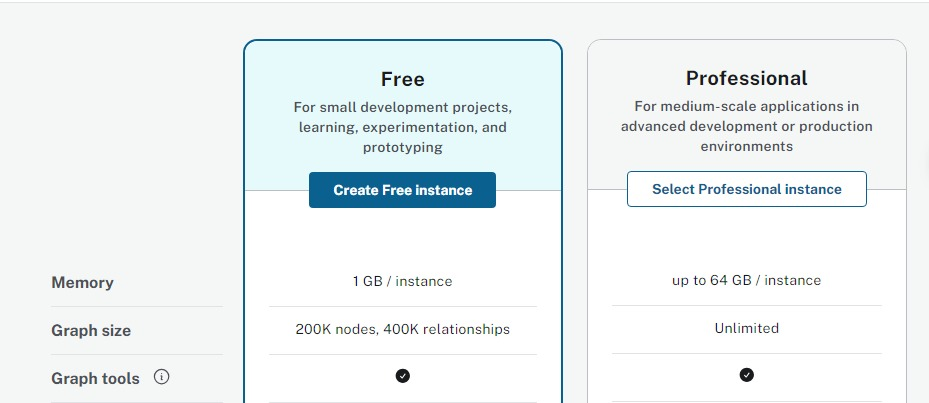

After you select "Create Free Instance" on the above screen, you'll be shown a modal window with your credentials to connect to the new instance. Copy them down to a safe place (or click "Download and continue") and enter them into the cell below.

In [ ]:
from neo4j import GraphDatabase
from google.colab import userdata

url = userdata.get('NEO4J_URI')
username ="neo4j"
password = userdata.get('NEO4J_PASSWORD')

driver = GraphDatabase.driver(url, auth=(username, password))

### Ingest the data into Neo4j

Below, we iterate through all the nodes and relationships in our in-memory NetworkX graph and upload them to Neo4j.

Note that for our nodes, we give them a base label we call `__Entity__` as well as their individual type from the above taxonomy. We have lifted this design choice from the [Neo4jGraph source code](https://api.python.langchain.com/en/latest/_modules/langchain_community/graphs/neo4j_graph.html#Neo4jGraph.add_graph_documents) that Neo4j contributed to Langchain. Later, when we create a vector index for the graph, this allows us to more efficiently index all the nodes together for vector search.

In [ ]:
def add_graph_to_neo4j(driver, graph):
    with driver.session() as session:
        # Add Nodes
        for node, attrs in graph.nodes(data=True):
            cypher_query = """
            MERGE (n:__Entity__ {{name: $name, entity: $entity}})
            SET n += $props
            WITH n
            CALL apoc.create.addLabels( n, ['{label}'] ) YIELD node
            RETURN distinct 'done' AS result
            """.format(label=attrs['entity'])  # Dynamically set the label based on the 'entity' attribute
            session.run(cypher_query, name=node, entity=attrs['entity'], props={k: v for k, v in attrs.items() if k not in ['entity']})

        # Add Edges
        for source, target, attrs in graph.edges(data=True):
            cypher_query = """
            MATCH (a),(b)
            WHERE a.name = $source AND b.name = $target
            MERGE (a)-[r:{relationship}]->(b)
            SET r += $props
            """.format(relationship=attrs['relationship'])  # Dynamically set the relationship type
            session.run(cypher_query, source=source, target=target, props={k: v for k, v in attrs.items() if k not in ['relationship']})

# Finally, call the function to add your graph to Neo4j
add_graph_to_neo4j(driver, G)


## Expanding the graph from unstructured text fields with LLMs and pre-defined schema types

Graph RAG really shines when you have large amounts of unstructured text data which contain many and complex relationships. In fact, most publicly available examples and demos you see for Graph RAG involve unstructured text as the primary data sources. In our case, with the structured dataset of hotel reviews, we can turn to the hotel descriptions for such data. Let's now look at how to build a pipeline for entity and relationship extraction from unstructured text.

In [ ]:
from typing import Optional, List, Dict, Any
from openai import OpenAI
import json

class Neo4jGraphExtractor:
    def __init__(self, openai_client: OpenAI, neo4j_driver: GraphDatabase, entity_types: List[str], rel_types: List[str], temperature: float = 0 ):
        self.client = openai_client
        self.temperature = temperature
        self.driver = driver
        self.entity_types = entity_types
        self.rel_types = rel_types


    def _create_prompt(self, hotel_name: str, text: str) -> str:
        return f"""
-Goal-
Given a text document that contains the description of a specific hotel and a list of entity types, identify all entities of those types from the text and all relationships among the identified entities.

-Steps-
1. Identify all entities. There is a known root entity, which is the described hotel. For each identified entity, extract the following information:
- entity_name: Name of the entity, capitalized
- entity_type: One of the following types: [{self.entity_types}]
- entity_description: Comprehensive description of the entity's attributes and activities

2. From the entities identified in step 1, identify all pairs of (source_entity, target_entity) that are clearly related to each other.

For each pair of related entities, extract:
- source_entity: name of the source entity
- target_entity: name of the target entity
- relationship_type: One of the following types: {self.rel_types}

3. Return output as a single JSON list containing all entities and relationships.

-Real Data-
######################
Root hotel: {hotel_name}
text: {text}
######################
output:
"""

    def _parse_llm_response(self, response: str) -> Dict[str, List[Dict[str, Any]]]:
      try:
          # Clean up markdown formatting if present
          if response.startswith('```'):
              # Extract content between code blocks
              response = response.split('```')[1]
              # Remove json language identifier if present
              if response.startswith('json'):
                  response = response[4:]
              response = response.strip()

          # Parse JSON
          try:
              data = json.loads(response)

              # Handle both direct entity/relationship format and nested format
              if isinstance(data, dict) and 'entities' in data and 'relationships' in data:
                  return {
                      "entities": data['entities'],
                      "relationships": data['relationships']
                  }
              if isinstance(data, list) and len(data) > 0:
                  # Original format handling
                  entities = [item for item in data if "type" in item]
                  relationships = [item for item in data if "relationship" in item]
                  return {
                      "entities": entities,
                      "relationships": relationships
                  }
              # Fallback if data is not in any expected shape
              return {"entities": [], "relationships": []}

          except json.JSONDecodeError as e:
              # If standard format fails, try the alternative format
              print(f"JSONDecodeError thrown in inner block: {str(e)}")
              if str(e).startswith("Extra data"):
                try:
                  # Assuming the format is [entities_list, relationships_list]
                  wrapped = f"[{response}]"
                  arr = json.loads(wrapped)
                  if len(arr) == 2:
                    entities_list, relationships_list = arr
                    return {
                        "entities": entities_list,
                        "relationships": relationships_list
                    }
                except json.JSONDecodeError:
                  raise e
              else:
                  # If neither format works, raise the original error
                  raise e
      except json.JSONDecodeError as e:
          print(f"Error parsing JSON response: {str(e)}")
          print("Response was:", response)
          return {"entities": [], "relationships": []}

    def process_text(self, hotel_name: str, text: str) -> Dict[str, List[Dict[str, Any]]]:
        """
        Process a hotel description text and extract entities and relationships.

        Args:
            hotel_name: Name of the hotel (root entity)
            text: Hotel description text to process

        Returns:
            Dictionary containing lists of extracted entities and relationships
        """
        prompt = self._create_prompt(hotel_name, text)

        response = self.client.chat.completions.create(
            model="gpt-4o-mini",  # or your preferred model
            temperature=self.temperature,
            messages=[
                {"role": "system", "content": "You are a helpful assistant that extracts entities and relationships from text and returns them in JSON format."},
                {"role": "user", "content": prompt}
            ]
        )

        # Extract the content from the response
        result = response.choices[0].message.content

        # Parse and return the structured data
        return self._parse_llm_response(result)

    def process_and_save(self, hotel_name: str, text: str) -> Dict[str, List[Dict[str, Any]]]:
        """
        Process hotel description text, extract entities and relationships, and save to Neo4j.

        Args:
            hotel_name: Name of the hotel (root entity)
            text: Hotel description text to process

        Returns:
            Dictionary containing lists of extracted entities and relationships
        """
        try:
            result = self.process_text(hotel_name, text)

            if result == {"entities": [], "relationships": []}:
                print(f"No entities or relationships found for {hotel_name}, skipping upload")
                return result
            print(f"Processing and saving result {result}")

            # Save to Neo4j within a single session
            with self.driver.session() as session:
                # Add entities
                for entity in result['entities']:
                    cypher_query = """
                    MERGE (n:__Entity__ {name: $name})
                    SET n.entity = $type,
                        n.description = $description
                    WITH n
                    CALL apoc.create.addLabels(n, [$type]) YIELD node
                    RETURN distinct 'done' AS result
                    """
                    session.run(
                        cypher_query,
                        name=entity['entity_name'],
                        type=entity['entity_type'].upper(),
                        description=entity['entity_description']
                    )

                # Add relationships
                for rel in result['relationships']:
                    # Format the relationship type directly into the query
                    cypher_query = f"""
                    MATCH (a:__Entity__), (b:__Entity__)
                    WHERE a.name = $source AND b.name = $target
                    MERGE (a)-[r:{rel['relationship_type']}]->(b)
                    RETURN distinct 'done' AS result
                    """
                    session.run(
                        cypher_query,
                        source=rel['source_entity'],
                        target=rel['target_entity']
                    )

            return result

        except Exception as e:
            print(f"Error processing hotel {hotel_name}: {str(e)}")
            return {"entities": [], "relationships": []}


    def process_from_dataframe(self,
                             dataset: pd.DataFrame,
                             name_column: str,
                             description_column: str,
                             batch_size: Optional[int] = None):
        """Process hotels from pandas DataFrame"""
        total = len(dataset)
        for idx, row in dataset.iterrows():
            print(f"Processing hotel {idx + 1}/{total}: {row[name_column]}")
            self.process_and_save(
                hotel_name=row[name_column],
                text=row[description_column]
            )

            if batch_size and (idx + 1) % batch_size == 0:
                print(f"Completed batch of {batch_size} hotels")

    def process_from_neo4j(self, batch_size: Optional[int] = None):
        """Process hotels from existing Neo4j HOTEL nodes"""
        with self.driver.session() as session:
            # First, count total hotels
            count_query = """
            MATCH (h:HOTEL)
            RETURN count(h) as total
            """
            total = session.run(count_query).single()['total']

            # Then process in batches if specified
            query = """
            MATCH (h:HOTEL)
            RETURN h.name as name, h.description as description
            """
            if batch_size:
                query += f" SKIP $skip LIMIT {batch_size}"

            processed = 0
            while processed < total:
                results = session.run(query, skip=processed)
                for record in results:
                    processed += 1
                    if record['description'] is None:
                        print(f"Skipping hotel {processed}/{total}: {record['name']} (no description)")
                        continue
                    print(f"Processing hotel {processed}/{total}: {record['name']}")
                    self.process_and_save(
                        hotel_name=record['name'],
                        text=record['description']
                    )

                if batch_size:
                    print(f"Completed batch of {batch_size} hotels")

    def process_hotels(self,
                      source: str = 'neo4j',
                      dataset: Optional[pd.DataFrame] = None,
                      name_column: Optional[str] = None,
                      description_column: Optional[str] = None,
                      batch_size: Optional[int] = None):
        """
        Unified interface for processing hotels from either source

        Args:
            source: Either 'neo4j' or 'dataframe'
            dataset: Required if source is 'dataframe'
            name_column: Required if source is 'dataframe'
            description_column: Required if source is 'dataframe'
            batch_size: Optional batch size for processing
        """
        if source == 'neo4j':
            self.process_from_neo4j(batch_size=batch_size)
        elif source == 'dataframe':
            if not all([dataset is not None,
                       name_column is not None,
                       description_column is not None]):
                raise ValueError("Dataset and column names required for DataFrame source")
            self.process_from_dataframe(
                dataset=dataset,
                name_column=name_column,
                description_column=description_column,
                batch_size=batch_size
            )
        else:
            raise ValueError("Source must be either 'neo4j' or 'dataframe'")

In [ ]:
openai_client = OpenAI()
extractor = Neo4jGraphExtractor(openai_client=openai_client,
                                neo4j_driver=driver,
                                entity_types = ["HOTEL", "AMENITY", "TOURIST_ATTRACTION"],
                                rel_types=["HAS_AMENITY", "LOCATED_NEARBY"])

# Process from Neo4j:
extractor.process_hotels(source='neo4j', batch_size=100)



Skipping hotel 1/149: Royal National Hotel (no description)
Processing hotel 2/149: Grant Plaza Hotel
Processing and saving result {'entities': [{'entity_name': 'Grant Plaza Hotel', 'entity_type': 'HOTEL', 'entity_description': 'Grant Plaza Hotel is a limited service boutique hotel located in the heart of the city. It is recommended by many travellers as one of the best valued hotels in San Francisco. The hotel caters to both business and pleasure travelers, and is the perfect place for a vacation getaway. The Hotel has just a completed renovation in 2015. The comfortable guestrooms are appointed with contemporary furnishings, and have recently been renovated for guest convenience with hairdryer, electronic keycard lock and free (WiFi) high speed internet access.'}, {'entity_name': 'Chinatown', 'entity_type': 'TOURIST_ATTRACTION', 'entity_description': 'Chinatown is a vibrant neighborhood in San Francisco known for its rich culture, dining options, and shopping experiences.'}, {'entity

Our knowledge graph has now been augmented with additional fact triplets about the hotels. With the data in place, we can next create a vector index over the text properties, exposing all of our nodes to HNSW similarity search.

## Build database indices for the graph

In [ ]:
import os
from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain.embeddings.openai import OpenAIEmbeddings

vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password,
    index_name='reviews',
    node_label="__Entity__",
    text_node_properties=['name', 'description', 'text'],
    embedding_node_property='embedding',
)


In [ ]:
response = vector_index.similarity_search(
    "What positive things are said about the Sirdeci Mansion Hotel?"
)

In [ ]:
print(response[0].page_content)

In [ ]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI

vector_qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(),
    chain_type="stuff",
    retriever=vector_index.as_retriever()
)
vector_qa.run(
    "What positive things are said about the Sirdeci Mansion Hotel?"
)

In [ ]:
# Customization of Langchain's GraphCypherQAChain prompt templates - this isn't relevant to our overall technique walkthrough

# We adjust the text2Cyper generation template only because we've now added an `embedding` property to most of our nodes,
# and if our LLM's generated queries return the whole node, the extremely token-heavy `embedding` vectors will overwhelm the context window
# (see https://github.com/langchain-ai/langchain/issues/22755)

# We adjust the QA template only to improve the failure rate of the LLM's answer generations
# (see https://community.neo4j.com/t/langchain-llm-return-no-output-even-when-the-returned-context-is-not-empty/66231/2)
from langchain.prompts import PromptTemplate

CYPHER_GENERATION_TEMPLATE = """Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema. However, always exclude the schema's `embedding` property from the Cypher statement.
Do not use any other relationship types or properties that are not provided.
Schema:
{schema}
Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.

The question is:
{question}

Cypher Query:
"""

CYPHER_QA_TEMPLATE = """You are an assistant that helps to form nice and human understandable answers.
The information part contains the provided information that you must use to construct an answer.
The provided information is authoritative, you must never doubt it or try to use your internal knowledge to correct it.
Make the answer sound as a response to the question. Do not mention that you based the result on the given information.
Here is an example:

Question: Which customers are associated with Traversaal.ai?
Context:[{{'Customer': 'Guruhotel'}}, {{'Customer': 'Tripsby.ai'}}]
Helpful Answer: The customers Guruhotel and Tripsby.ai are associated with Traversaal.ai

Follow this example when generating answers.
If the provided information is empty, say that you don't know the answer.

Information:
{context}

Question: {question}
Helpful Answer:"""

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=CYPHER_GENERATION_TEMPLATE
)

CYPHER_QA_PROMPT = PromptTemplate(
    input_variables=["context", "question"], template=CYPHER_QA_TEMPLATE
)


In [ ]:
from langchain.chains import GraphCypherQAChain
from langchain.graphs import Neo4jGraph

graph = Neo4jGraph(
    url=url,
    username=username,
    password=password,
    enhanced_schema=True
)

graph.refresh_schema()

cypher_chain = GraphCypherQAChain.from_llm(
    cypher_llm = ChatOpenAI(temperature=0, model_name='gpt-4'),
    qa_llm = ChatOpenAI(temperature=0),
    graph=graph,
    verbose=True,
    qa_prompt=CYPHER_QA_PROMPT,
    cypher_prompt=CYPHER_GENERATION_PROMPT
)

# Querying the knowledge graph RAG

The graph RAG can run logical operators on the data:

In [ ]:
cypher_chain.run(
    "How many reviews does the Romance Istanbul Hotel have?"
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (h: HOTEL {name: "Romance Istanbul Hotel"})-[:HAS_REVIEW]->(r: REVIEW)
RETURN COUNT(r) as ReviewCount
Full Context:
[{'ReviewCount': 3}]

> Finished chain.


'The Romance Istanbul Hotel has 3 reviews.'

In [ ]:
cypher_chain.run(
    "Which hotel has the most reviews?"
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (h:HOTEL)-[:HAS_REVIEW]->(r:REVIEW)
RETURN h.name, COUNT(r) AS reviews
ORDER BY reviews DESC
LIMIT 1
Full Context:
[{'h.name': 'Hotel Astoria - Astotel', 'reviews': 5}]

> Finished chain.


'Hotel Astoria - Astotel has 5 reviews.'

The graph RAG can answer questions that require reasoning over multiple "hops" of relationships:

In [ ]:
cypher_chain.run(
    "What positive things were said in reviews for hotels in San Francisco where the reviewer's trip date occurred in Fall 2023?"
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (h:HOTEL)-[:LOCATED_IN]->(l:LOCALITY {name: 'San Francisco'}), (h)-[:HAS_REVIEW]->(r:REVIEW)-[:ON_DATE]->(d:TRIP_DATE {name: 'Fall 2023'}), (r)-[:HAS_SENTIMENT]->(s:SENTIMENT {name: 'Positive'})
RETURN h.name, r.text
Full Context:
[{'h.name': 'BEI San Francisco, Trademark Collection by Wyndham', 'r.text': "Convenient location, affordable price, minimalistic, good beds and bathroom, modern, that about sums it up on the pro's. Expect to pay half of your overnight just for your car, on top, for parking. Don't expect the coffee machine to work. Don't expect two chairs to sit on (just one). No desk to work on. Cords hanging below the shallow shelf. There is no happy hour as the bar has been closed long time ago, don't go in the weekend if you want to feel like your lost in no-mansland, and don't expect atmosphere, except if you want to count security agents in that category. All in all, yes, can see how it might work for s

"The positive things mentioned in reviews for hotels in San Francisco where the reviewer's trip date occurred in Fall 2023 included clean rooms, friendly staff, secure parking, good breakfast, and convenient locations."

By the same token, the graph RAG can answer questions that require understanding of indirect relationships:

In [ ]:
cypher_chain.run(
    "What reviews were left for hotels in Turkiye?"
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (h:HOTEL)-[:LOCATED_IN]->(l:LOCALITY)-[:LOCATED_IN]->(c:COUNTRY {name: 'Turkiye'}), (h)-[:HAS_REVIEW]->(r:REVIEW)
RETURN h.name AS Hotel, r.name AS Review, r.text AS Review_Text
Full Context:
[{'Hotel': 'YOTEL Istanbul Airport Hotel (Landside)', 'Review': 'Great food\\$', 'Review_Text': 'Kommunity restaurant is very good! Every time we come through Istanbul for overnight between flights, we eat dinner here. Great food, great service. Our waiter Seref did a great job. Thank you, Seref, for the outstanding service! We had the lentil soup, spaghetti bolognese, salmon, and Tiramissu \\$'}, {'Hotel': 'YOTEL Istanbul Airport Hotel (Landside)', 'Review': 'Yotel Seref \\$', 'Review_Text': 'The staff was very accommodating and the service at komyunity was excellent. Thanks to Seref for a great experience he went above and beyond! I would definitely like to stay here again. Loved the margarita pizza.\\$'}, {'Hotel': 'Pell Palac

'There were reviews left for YOTEL Istanbul Airport Hotel (Landside), Pell Palace Hotel Spa, Pera Palace Hotel, and Ramada by Wyndham Istanbul Old City in Turkiye.'

## Combining vector RAG and graph RAG together in a single query interface

In [ ]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

tools = [
    Tool(
        name="Reviews",
        func=vector_qa.run,
        description="""Useful when you need to answer questions about descriptions of hotel reviews.
        Not useful for counting the number of reviews or performing other logical operations.
        Use full question as input.
        """,
    ),
    Tool(
        name="Graph",
        func=cypher_chain.run,
        description="""Useful when you need to answer questions about hotels,
        or their location. Also useful for any sort of
        aggregation like counting the number of reviews, etc.
        Use full question as input.
        """,
    ),
]

mrkl = initialize_agent(
    tools,
    ChatOpenAI(temperature=0, model_name='gpt-4'),
    agent=AgentType.OPENAI_FUNCTIONS, verbose=True
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


In [ ]:
response = mrkl.invoke({"input": "Which hotel says it has 39 rooms in its description?"})
print(response)



> Entering new AgentExecutor chain...

Invoking: `Graph` with `Which hotel says it has 39 rooms in its description?`




> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (h:HOTEL) WHERE h.description CONTAINS '39 rooms' RETURN h.name
Full Context:
[{'h.name': 'Romance Istanbul Hotel'}]

> Finished chain.
The hotel Romance Istanbul Hotel says it has 39 rooms in its description.The hotel that says it has 39 rooms in its description is the Romance Istanbul Hotel.

> Finished chain.
{'input': 'Which hotel says it has 39 rooms in its description?', 'output': 'The hotel that says it has 39 rooms in its description is the Romance Istanbul Hotel.'}


In [ ]:
response = mrkl.run("What negative things were said about the Romance Istanbul Hotel?")
print(response)



> Entering new AgentExecutor chain...

Invoking: `Reviews` with `What negative things were said about the Romance Istanbul Hotel?`


The negative comment about the Romance Istanbul Hotel was that there was a bad smell coming from the sink drain, which the hotel should address.Some guests at the Romance Istanbul Hotel have reported a bad smell coming from the sink drain.

> Finished chain.
Some guests at the Romance Istanbul Hotel have reported a bad smell coming from the sink drain.


# Comparing Vector RAG vs Graph RAG: A Practical Analysis

When implementing RAG systems, it's crucial to understand when graph-based approaches offer meaningful advantages over traditional vector RAG. Let's examine some real queries against our hotel reviews knowledge graph to understand these tradeoffs.

## Case Study 1: Multi-Hop Queries
### Query: "What highly-rated hotels near Fisherman's Wharf offer free Wi-Fi and easy access to cable cars?"

#### Vector RAG Response:
> *Two highly-rated hotels near Fisherman's Wharf that offer free Wi-Fi and easy access to cable cars are
San Francisco Marriott Fisherman's Wharf and Hotel Riu Plaza Fisherman's Wharf.*

#### Graph RAG Response:
Using the following Cypher for the retrieval:
```cypher
MATCH (h:HOTEL)-[:LOCATED_NEARBY]->(fw:TOURIST_ATTRACTION {name: 'Fisherman\'s Wharf'}),
      (h)-[:HAS_AMENITY]->(wifi:AMENITY {name: 'Free Wi-Fi'}),
      (h)-[:LOCATED_NEARBY]->(cc:TOURIST_ATTRACTION {name: 'San Francisco Cable Car line'}),
      (h)-[:HAS_REVIEW]->(r:REVIEW)
WHERE r.rating_value >= 4.0
RETURN DISTINCT h.name
```

>*The Hotel Riu Plaza Fisherman’s Wharf, located in San Francisco, offers free Wi-Fi and easy access to the San Francisco Cable Car line.*

#### Analysis:
1. **Accuracy**: Vector RAG incorrectly includes SF Marriott, which doesn't mention free Wi-Fi in its description. Graph RAG correctly identifies only Hotel Riu by following explicit relationships.

2. **Query Processing**:
   - Vector RAG attempts to infer relationships from text proximity
   - Graph RAG follows verified relationship paths
   - Multi-hop queries strongly favor graph approach

3. **Confidence**: Graph RAG can guarantee the existence of relationships, while vector RAG makes best guesses

## Case Study 2: Amenity Comparisons
### Query: "Compare amenities and ratings for hotels near Fisherman's Wharf and Pier 39"

Vector RAG Response:
```
Based on the information provided:

1. **San Francisco Marriott Fisherman's Wharf**:
   - Amenities: Fitness Center, Handicap Accessible Rooms, Safety Deposit Boxes, Iron, Ironing Board, Hairdryers.
   - Rating: No specific rating mentioned.

2. **Hotel Riu Plaza Fisherman’s Wharf**:
   - Amenities: Free WiFi, Outdoor Pool, Gym, Conference Rooms, Satellite TV, Mini-fridge, Coffee Machine, AC, Buffet Breakfast, Grab & Go Bar.
   - Rating: No specific rating mentioned.

3. **Hotel Zephyr San Francisco**:
   - Amenities: Not specified in the provided information.
   - Rating: No specific rating mentioned.

4. **PIER 39**:
   - Amenities: Shops, Restaurants, Sea lions.
   - Rating: No specific rating mentioned.

Unfortunately, the information provided does not include specific ratings for the hotels near Fisherman's Wharf and Pier 39, so I cannot provide a direct comparison in terms of ratings. If you have a specific rating range in mind or other criteria for comparison, please let me know.
```

Graph RAG Response:

```
The Hyatt Centric Fisherman's Wharf San Francisco and Hotel Riu Plaza Fisherman’s Wharf are two hotels near both Fisherman's Wharf and PIER 39.

The Hyatt Centric offers amenities such as Brick & Beam, a Fitness Center, Free Wi-Fi, Meeting Rooms, and a Relaxing Pool. It has an average rating of 4.33.

The Hotel Riu Plaza provides amenities like a Buffet Breakfast Service, a Bar, a Minibar, a TV with Free Movies, and Coffee and Tea Facilities. It has an average rating of 4.0.
```

#### Analysis:
1. **Structured Data**: Graph RAG excels at comparing discrete attributes
2. **Relationship Context**: Understanding nearness to multiple landmarks
3. **Aggregation**: Can compute statistics across relationship patterns

## Key Findings

### When to Use Graph RAG:
1. **Relationship-Critical Queries**
   - Multiple hops required (e.g., "hotels near X with amenity Y")
   - Relationship accuracy matters
   - Complex pattern matching

2. **Structured Comparisons**
   - Comparing entities across relationships
   - Aggregating across relationship patterns
   - Need for verified connections

3. **Hybrid Questions**
   - Combining factual relationships with semantic search
   - Need both structured and unstructured insights

### When Traditional Vector RAG Suffices:
1. **Simple Semantic Queries**
   - Single-entity questions
   - General descriptions or summaries
   - No relationship traversal needed

2. **Fuzzy Matching**
   - When exact relationship matching isn't critical
   - Flexible interpretation acceptable
   - General sentiment or topic analysis

## Implementation Considerations

1. **Data Quality Requirements**
   - Graph RAG requires explicit relationship modeling
   - Higher upfront cost in knowledge graph construction
   - Need for relationship maintenance/updates

2. **Query Complexity**
   - Graph queries can be more complex to construct
   - Need for query optimization
   - Hybrid approaches often optimal

3. **System Architecture**
   - Graph databases add operational complexity
   - Vector indices still valuable for semantic search
   - Consider hybrid architectures for complex applications


